In [279]:
import pandas as pd
import numpy as np
import scipy as sp
import sklearn
import matplotlib.pyplot as plt
import sys
from nltk.corpus import stopwords
import nltk
from gensim.models import ldamodel, CoherenceModel
import gensim.corpora
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
import re
import string
import spacy
import pickle
import seaborn as sns

# 2a

## Split df by value  
Here we split the data into groups based on question value. The analytical goal is to analyze the difficulty of questions across years by dollar value of each question. Therefore, it's important to only include values where the dollar value represents the difficulty of the question and ignore values like daily doubles and final jeopardy where the player determines the value of their response. Since the values on the board have changed over the years, we can't necessarily use the divisible-by-100 pattern that's used on Jeopardy today. Instead, we have taken \\$2000 as the maximum point value and binned all lower values into groups of \\$200.

In [80]:
# only take rows from Jeopardy and Double Jeopardy
df_ = df.loc[(df['round'] == 'Jeopardy!') | (df['round'] == 'Double Jeopardy!')]
#df _ df_[df_['value'].isin([3, 6])]

# only takes values <= $2000
df_ = df_[df_['value']<=2000]
df_ = df_.sort_values('value')

# bin dollar values into groups of every $200
bins =  np.arange(0, 18000, 200)
ind = np.digitize(df_['value'], bins)

# assign group label to each dollar value 
df_['value_group'] = ind

## Plot Range of values for all topics  
Here, I plot the unique values for each topic. The colors represent the Jeopardy categories.

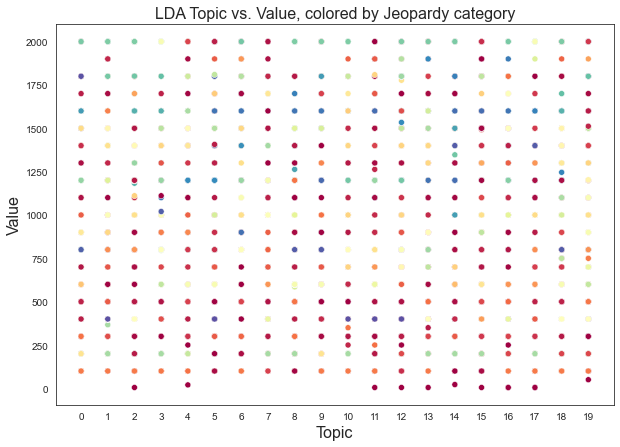

In [305]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(x=df_['topic'],y=df_['value'], hue=df_['category'], palette='Spectral', legend=False)
ax.set_xticks(range(20))
ax.set_xlabel('Topic', size=16)
ax.set_ylabel('Value', size=16)
ax.set_title('LDA Topic vs. Value, colored by Jeopardy category', size=16)
plt.show()

It appears that pretty much every topic appears with every value at least once. There does not seem to be a relationship between the LDA topics and the Jeopardy! categories, or the colors would be arranged in vertical stripes along the x-axis.

## Plot top 5 topics for each monetary value

In [219]:
a = df_.groupby(['value_group','topic']).size().to_frame('count').reset_index()
a = a.sort_values(['value_group','count'], ascending=[True,False])
topk_topics = a.groupby('value_group').head(5).reset_index()

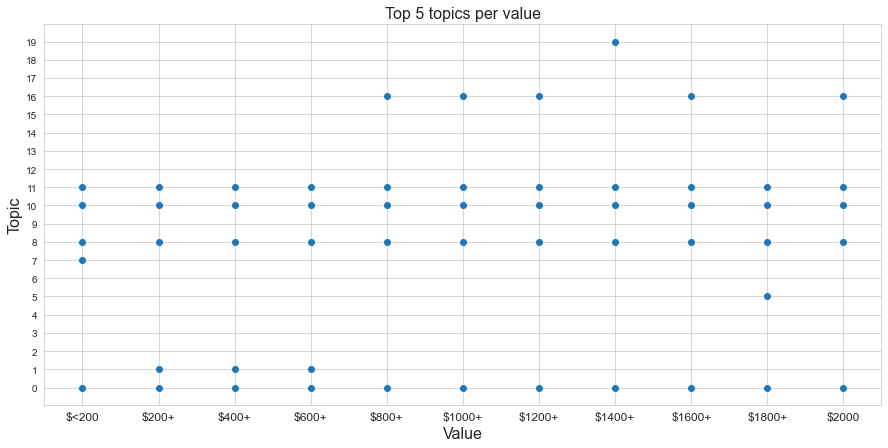

In [271]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(15,7))
bins = ['$<200', '$200+', '$400+', '$600+', '$800+', '$1000+',\
 '$1200+', '$1400+', '$1600+', '$1800+', '$2000']
sns.scatterplot(x=topk_topics['value_group'], y=topk_topics['topic'], s=60)
ax.set_title('Top 5 topics per value', size=16)
ax.set_xticks(range(1,12))
ax.set_xticklabels(bins, size=12)
ax.set_yticks(range(20))
ax.set_xlabel('Value', size=16)
ax.set_ylabel('Topic', size=16)
plt.show()

It looks like the top 5 topics are mostly the same for each value bin, but there are a few topics (16, 19, and 5) that only appear in more valuable, or "harder" questions. Let's take a look at the words in those 2 topics.

In [262]:
hard_topics = pd.DataFrame()

In [268]:
topic16 = lda.show_topic(16, topn = 15)
hard_topics['topic_16'] = [i[0] for i in topic16]
topic19 = lda.show_topic(19, topn = 15)
hard_topics['topic_19'] = [i[0] for i in topic19]
topic5 = lda.show_topic(5, topn = 15)
hard_topics['topic_5'] = [i[0] for i in topic5]
hard_topics.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
topic_16,play,crew,win,show,clue,team,report,night,name,boy,host,latin,actress,break,accord
topic_19,year,write,begin,book,end,number,point,change,flag,inspire,sister,director,side,center,novel
topic_5,get,group,form,novel,base,could,publish,name,element,guy,receive,call,cross,treat,object


Topic 16 apprease to be sports related, topic 19 appears to be book or story related. There doesn't appear to be a clear pattern with topic 5.

## Plot top 5 monetary values for each topic

In [176]:
b = a.sort_values(['topic','count'], ascending=[True,False])
topk_values = b.groupby('topic').head(5).reset_index()

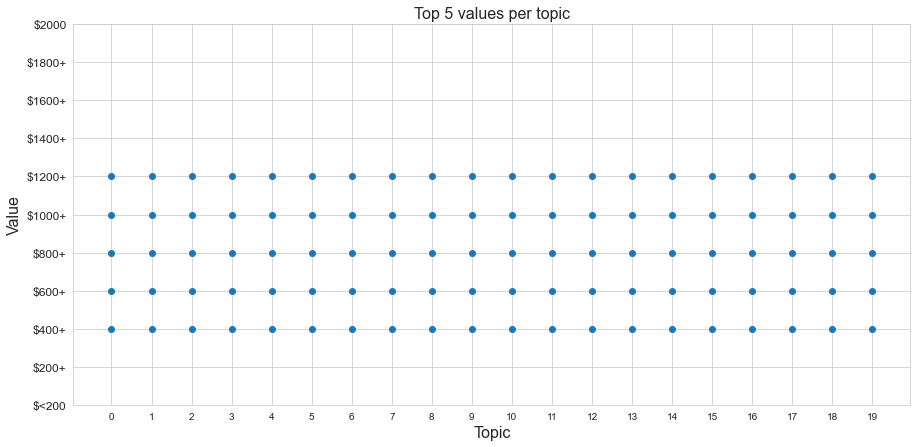

In [272]:
fig, ax = plt.subplots(figsize=(15,7))
bins = ['$<200', '$200+', '$400+', '$600+', '$800+', '$1000+',\
 '$1200+', '$1400+', '$1600+', '$1800+', '$2000']
sns.scatterplot(x=topk_values['topic'], y=topk_values['value_group'], s=60)
ax.set_title('Top 5 values per topic', size=16)
ax.set_xticks(range(20))
ax.set_yticks(range(11))
ax.set_yticklabels(bins, size=12)
ax.set_xlabel('Topic', size=16)
ax.set_ylabel('Value', size=16)
plt.show()

Each topic has the same top 5 values. This suggests that the same 5 values are most common in Jeopardy! overall.